In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
import scanpy as sc 
import commot as ct

import sys
sys.path.append('../src')

In [3]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4.h5ad')
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')

In [4]:
from spaceoracle.tools.utils import scale_adata

adata = scale_adata(adata, cell_size=10)
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

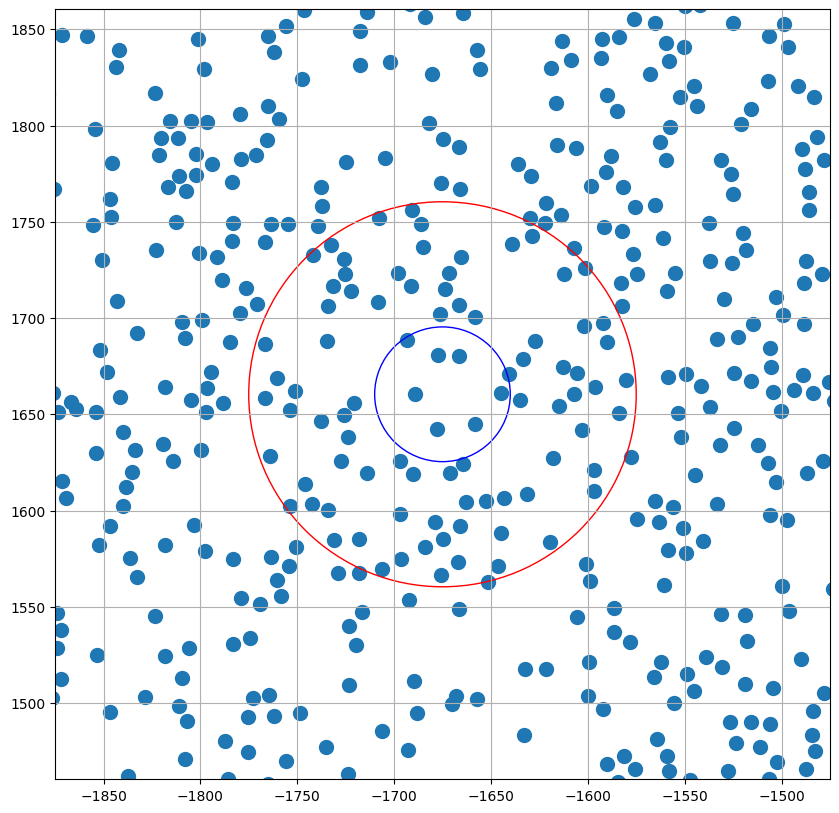

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(adata.obsm['spatial'][:, 0],  adata.obsm['spatial'][:, 1], s=100)
plt.grid()

center_x = adata.obsm['spatial'][:, 0].mean()
center_y = adata.obsm['spatial'][:, 1].mean()
plt.xlim(center_x-200, center_x+200)
plt.ylim(center_y-200, center_y+200)

circle1 = plt.Circle((center_x, center_y), 100, color='r', fill=False)
circle2 = plt.Circle((center_x, center_y), 35, color='b', fill=False)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

plt.show()

In [20]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4_colinks.pkl',
    organism='mouse',
    annot='cell_type_int'
)

from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata=adata,
    target_gene='Supt4b',
    layer='imputed_count',
    cluster_annot='cell_type_int', 
    grn=co_grn,
    radius=100,
    contact_distance=30
)

In [21]:
estimator.fit(num_epochs=1, learning_rate=5e-3, score_threshold=0.1)

Fitting Supt4b with 276 modulators
	19 Transcription Factors
	208 Ligand-Receptor Pairs
	49 TranscriptionFactor-Ligand Pairs
0: -0.5178 | 0.0846
1: -0.3127 | 0.1834
2: -0.5467 | 0.1497
3: -0.4472 | 0.1333
4: -0.8517 | 0.2717
5: -0.5676 | 0.2735
6: -0.7667 | 0.3337


In [23]:
estimator.lr

,ligand,receptor,pathway,signaling,radius,pairs
0,Tgfb1,Tgfbr1,TGFb,Secreted Signaling,100,Tgfb1$Tgfbr1
0,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,100,Tgfb1$Tgfbr2
2,Tgfb3,Tgfbr1,TGFb,Secreted Signaling,100,Tgfb3$Tgfbr1
2,Tgfb3,Tgfbr2,TGFb,Secreted Signaling,100,Tgfb3$Tgfbr2
97,Gdf15,Tgfbr2,GDF,Secreted Signaling,100,Gdf15$Tgfbr2
...,...,...,...,...,...,...
2009,Siglec1,Spn,SN,Cell-Cell Contact,30,Siglec1$Spn
2014,Tigit,Pvr,TIGIT,Cell-Cell Contact,30,Tigit$Pvr
2015,Itga4,Vcam1,VCAM,Cell-Cell Contact,30,Itga4$Vcam1
2015,Itgb1,Vcam1,VCAM,Cell-Cell Contact,30,Itgb1$Vcam1


In [5]:
from spaceoracle.tools.network import DayThreeRegulatoryNetwork
import anndata as ad

def generate_realistic_data(noise_level=0.1):
    np.random.seed(42)
    adata = ad.read_h5ad('/ix/djishnu/alw399/SpaceOracle/data/slideseq/day3_1.h5ad')

    grn = DayThreeRegulatoryNetwork()

    regulators = grn.get_regulators(adata, 'Cd74')[:5]

    adata = adata[:, adata.var_names.isin(regulators+['Cd74']+['Il2', 'Il2ra', 'Ccl5', 'Bmp2', 'Bmpr1a'])]

    adata = adata[adata.obs['rctd_cluster'].isin([0, 1])]
    adata = adata[:600, :]

    adata.obs['rctd_cluster'] = adata.obs['rctd_cluster'].cat.remove_unused_categories()

    adata.layers['imputed_count'] = adata.X.toarray().copy()
    adata.layers['normalized_count'] = adata.layers['imputed_count'].copy()

    return adata

adata = generate_realistic_data()
adata

AnnData object with n_obs × n_vars = 600 × 11
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count'

In [6]:
ligands = ['Ccl5', 'Il2']
ligands_df = adata.to_df(layer='imputed_count')[ligands]

In [14]:
from spaceoracle.models.parallel_estimators import received_ligands
def generate_simulated_lr():
    sim_lr = pd.DataFrame({
        'ligand': {0: 'Tgfb1', 636: 'Ccl5', 647: 'Ccl5', 675: 'Ccl5', 719: 'Il2'},
        'receptor': {0: 'Tgfbr2',
            636: 'Ccr3',
            647: 'Ccr4',
            675: 'Ackr2',
            719: 'Il2rg'},
        'pathway': {0: 'TGFb', 636: 'CCL', 647: 'CCL', 675: 'CCL', 719: 'IL2'},
        'signaling': {0: 'Secreted Signaling',
            636: 'Secreted Signaling',
            647: 'Secreted Signaling',
            675: 'ECM-Receptor',
            719: 'Cell-Cell Contact'},
        'radius': {0: 30, 636: 30, 647: 30, 675: 10, 719: 10},
        'pairs': {0: 'Tgfb1$Tgfbr2',
            636: 'Ccl5$Ccr3',
            647: 'Ccl5$Ccr4',
            675: 'Ccl5$Ackr2',
            719: 'Il2$Il2rg'}
    })
    return sim_lr

def get_neighbors_within_radius(adata, radius):
    coords = adata.obsm['spatial']
    tree = KDTree(coords)
    neighbors = tree.query_ball_tree(tree, radius)
    return neighbors

sim_lr = generate_simulated_lr()

weighted_ligands = received_ligands(
    adata.obsm['spatial'],
    ligands_df, 
    sim_lr
)

In [16]:
from scipy.spatial import KDTree

neighbors = get_neighbors_within_radius(adata, 30)


In [19]:
sim_lr

,ligand,receptor,pathway,signaling,radius,pairs
0,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,30,Tgfb1$Tgfbr2
636,Ccl5,Ccr3,CCL,Secreted Signaling,30,Ccl5$Ccr3
647,Ccl5,Ccr4,CCL,Secreted Signaling,30,Ccl5$Ccr4
675,Ccl5,Ackr2,CCL,ECM-Receptor,10,Ccl5$Ackr2
719,Il2,Il2rg,IL2,Cell-Cell Contact,10,Il2$Il2rg


In [ ]:
for i, ligand_vals in enumerate(weighted_ligands['Ccl5']):
    raw_vals = bool(ligands_df['Ccl5'].iloc[neighbors[i]].sum())
    ligand_vals = bool(ligand_vals)

    assert raw_vals == ligand_vals, f'Failed for cell {i}'

for i, ligand_vals in enumerate(weighted_ligands['Ccl5']):
    raw_vals = bool(ligands_df['Il2'].iloc[neighbors[i]].sum())
    ligand_vals = bool(ligand_vals)

    assert raw_vals == ligand_vals, f'Failed for cell {i}'


In [5]:
from spaceoracle.prophets import Prophet

pythia = Prophet(
    adata=adata,
    models_dir='/ix/djishnu/shared/djishnu_kor11/super_filtered_runs/mLDN3-1_v4',
    annot='cell_type_int',
    annot_labels='cell_type',
    radius=100
)

In [6]:
pythia.compute_betas(subsample=10)

100%|██████████| 10/10 [00:00<00:00, 11.12it/s]
